# I can actually include this in the Thesis

In [1]:
from sbibm.metrics import c2st 

import numpy as np
import matplotlib.pyplot as plt
from torchdyn.core import NeuralODE, DEFunc
from tqdm import tqdm
from functools import partial
from dataclasses import asdict
from scipy.stats import gaussian_kde
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.functional import mse_loss


torch.set_printoptions(linewidth=1000) #nice prints

#own imports
from configurations.config_multimodal_5d import *
from utils import *


In [2]:
#get configuration
Config = Configuration()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Create mixture model

In [3]:
#distribution hyperparameters
d = 5
m = 2
mu = torch.tensor([[0.0,-2.5,2.5]]).repeat(d,1)
sigma = torch.tensor([2.0,1.0,1.0])
w = torch.tensor([0.5,0.5])
w = w/w.sum()

obs = torch.tensor([0. for _ in range(d)])
print(obs)

print(mu)
print(sigma)
print(w)

tensor([0., 0., 0., 0., 0.])
tensor([[ 0.0000, -2.5000,  2.5000],
        [ 0.0000, -2.5000,  2.5000],
        [ 0.0000, -2.5000,  2.5000],
        [ 0.0000, -2.5000,  2.5000],
        [ 0.0000, -2.5000,  2.5000]])
tensor([2., 1., 1.])
tensor([0.5000, 0.5000])


In [4]:
# for NN
x_dim = d
theta_dim = d
input_dim = 2*d + 1

In [5]:
def prior(n):
    return torch.randn(n,d) * sigma[0] + mu[:,0]


def simulator(theta):
    u = torch.rand(size = [theta.shape[0]]).repeat(m,1).T       #[n,m]
    threshold = w.cumsum(0).repeat(theta.shape[0],1)            #[n,m]
    ass = (u > threshold).sum(axis = 1) #[n] index from 0 to m-1
    s_ = sigma[ass + 1][:,None]
    m_ = mu[:, ass + 1].T
    return theta + torch.randn_like(theta)*s_ + m_


def posterior(n, obs, detail = False):
    #creating new variance
    a = 1/sigma**2 #[m+1]
    sigma_tilde = (a + a[0])[1:] ** -0.5 #[m]

    #creating new mean
    demean = obs[:,None] - mu[:,1:]
    premu1 = torch.concatenate([mu[:,0][:,None],demean], axis = 1)
    premu2 = premu1 * a
    premu3 = (premu2 + premu2[:,0][:,None])[:,1:]
    mu_tilde = premu3 * sigma_tilde ** 2 

    #creating new weights
    premult = sigma[1:] * w/sigma_tilde
    square = (mu_tilde.T @ mu_tilde).diag() * sigma_tilde ** -2.0
    a1 = (mu[:,0]**2).sum() * a[0]
    a2 = (demean.T @ demean).diag() * a[1:]
    biga = a2 + a1
    exponent = -0.5 * (square + biga)
    unweighted = torch.exp(exponent) * premult
    w_tilde = unweighted/unweighted.sum()

    #sampling
    u = torch.rand(size = [n]).repeat(m,1).T            #[n,m]
    threshold = w_tilde.cumsum(0).repeat(n,1)           #[n,m]
    ass = (u > threshold).sum(axis = 1)                 # [n] index from 0 to m-1
    s_ = sigma_tilde[ass][:,None]
    m_ = mu_tilde[:,ass].T

    if detail:
        print(w_tilde,"\n",sigma_tilde,"\n",mu_tilde)
    return torch.randn(n,d) * s_ + m_


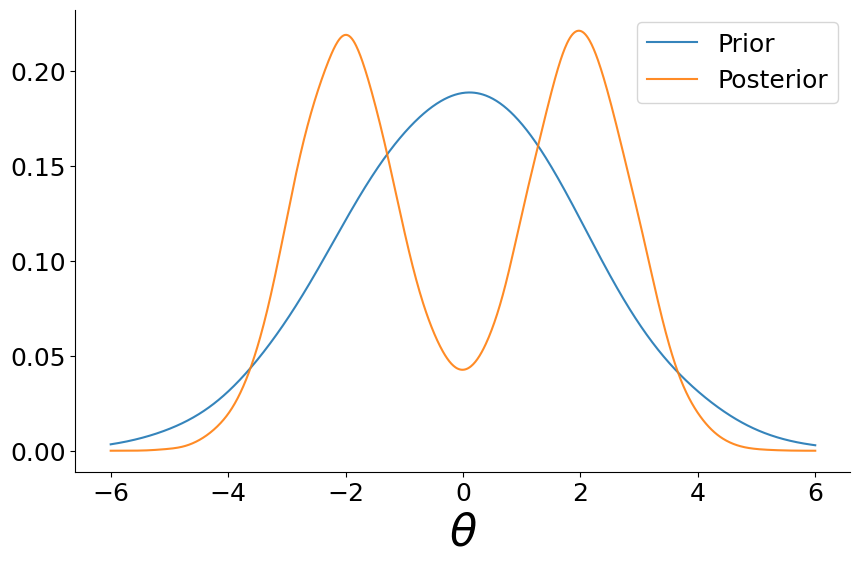

In [6]:
# # PLOT multimodal_prior_posterior

data_prior = prior(20000)
data_post = posterior(20000, obs)

x_values = np.linspace(-6,6, 1000)

kde_prior = gaussian_kde(data_prior[:,0], bw_method=0.3)(x_values)
kde_post = gaussian_kde(data_post[:,0], bw_method=0.1)(x_values)

plt.figure(figsize=(10, 6)) 
plt.tick_params(axis='both', which='major', labelsize=18)  

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)



plt.plot(x_values, kde_prior, label = "Prior", alpha = 0.9)
plt.plot(x_values, kde_post, label = "Posterior", alpha = 0.9)
# Checking smoothing is correct
# plt.hist(data_prior[:,0], bins = 100, density=True, alpha = 0.2)
# plt.hist(data_post[:,0], bins = 100, density=True, alpha =0.2)
plt.xlabel(r'$\theta$', fontsize = 32)
plt.legend(fontsize = 18, loc = "upper right")


# plt.savefig('plots/multimodal_prior_posterior.svg', format='svg', dpi=300)
# plt.savefig('plots/multimodal_prior_posterior.png', dpi=300)  # PNG with high DPI


plt.show()


# FMPE

In [7]:
#create dataset
n = Config.Dataset["n"]
tr_ind, val_ind = random_split(range(n), [0.98,0.02])
dataset = SbiDataset(prior,simulator,n) #[theta,x]
tr_dataloader = DataLoader(dataset[tr_ind],batch_size=Config.Train["batch"],shuffle=True, num_workers=0, drop_last=True)
val_dataloader = DataLoader(dataset[val_ind],batch_size=Config.Train["batch"],shuffle=False, num_workers=0, drop_last=True)
print(f"Epoch is {len(tr_dataloader)} batches, \nValidation is over {len(val_dataloader)} batches")


Epoch is 3062 batches, 
Validation is over 62 batches


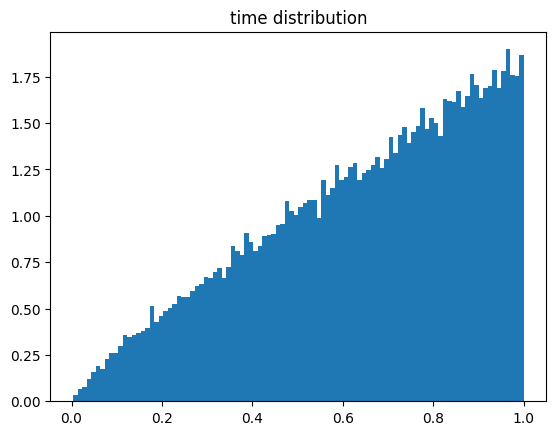

In [8]:
#create FMPE objective
if Config.FM["t_dist"] == "power_law":
    tdist = partial(power_law_, alpha = Config.FM["alpha"])
else:
    tdist = time_uniform

plt.hist(tdist(50000), bins = 100, density=True)
plt.title("time distribution")
plt.show()

FM = partial(FM_, sigma_min = Config.FM["sigma_min"], batch = Config.Train["batch"],device = device, t_dist = tdist)

In [9]:
#initialize NN,Optimizer,Diagnostics
model = MLP_FMPE(input_dim=input_dim, output_dim=theta_dim, **Config.NN)

@torch.no_grad()
def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_normal_(m.weight) 
model.apply(init_weights)
model.to(device)
print(f"The NN has {sum([p.nelement() for p in model.parameters()])} parameters")

optimizer = torch.optim.Adam(model.parameters(), **Config.Optimizer)
Diag = Diagnostics()

The NN has 135941 parameters


In [10]:
#Training Loop (remember to do a fresh NN init)
for epoch in tqdm(range(Config.Train["epochs"])):
    model.train()
    for theta_and_x in tr_dataloader: 
        # theta = theta_and_x[:,:theta_dim]
        # x = theta_and_x[:,theta_dim:]
        
        #forward pass
        input, ut = FM(theta_and_x[:,:theta_dim]) #input is [eta_t, t]
        full_input = torch.cat([theta_and_x[:,theta_dim:],input], dim = -1).to(device) #[x,eta_t,t]
        vt = model(full_input)
        loss = mse_loss(vt,ut)

        #backward pass
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()                #gradient update
        Diag.losses.append(loss.item()) #stats

    model.eval()
    Diag.epoch_tr_loss.append(np.mean(Diag.losses[-len(tr_dataloader):]))
    with torch.no_grad():
        #loss
        val_loss = 0
        for theta_and_x in val_dataloader:
            input, ut = FM(theta_and_x[:,:theta_dim])
            full_input = torch.cat([theta_and_x[:,theta_dim:],input], dim = -1).to(device) #[x,eta_t,t]
            vt = model(full_input)
            val_loss += mse_loss(vt,ut)
        val_loss /= len(val_dataloader)
        Diag.epoch_val_loss.append(val_loss)

    




100%|██████████| 300/300 [37:40<00:00,  7.54s/it]


final train loss: 1.486 (10 avg: 1.482), 
 final val loss: 1.496 (10 avg: 1.490)


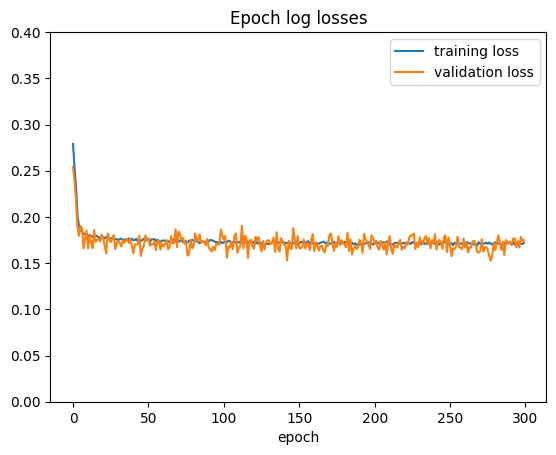

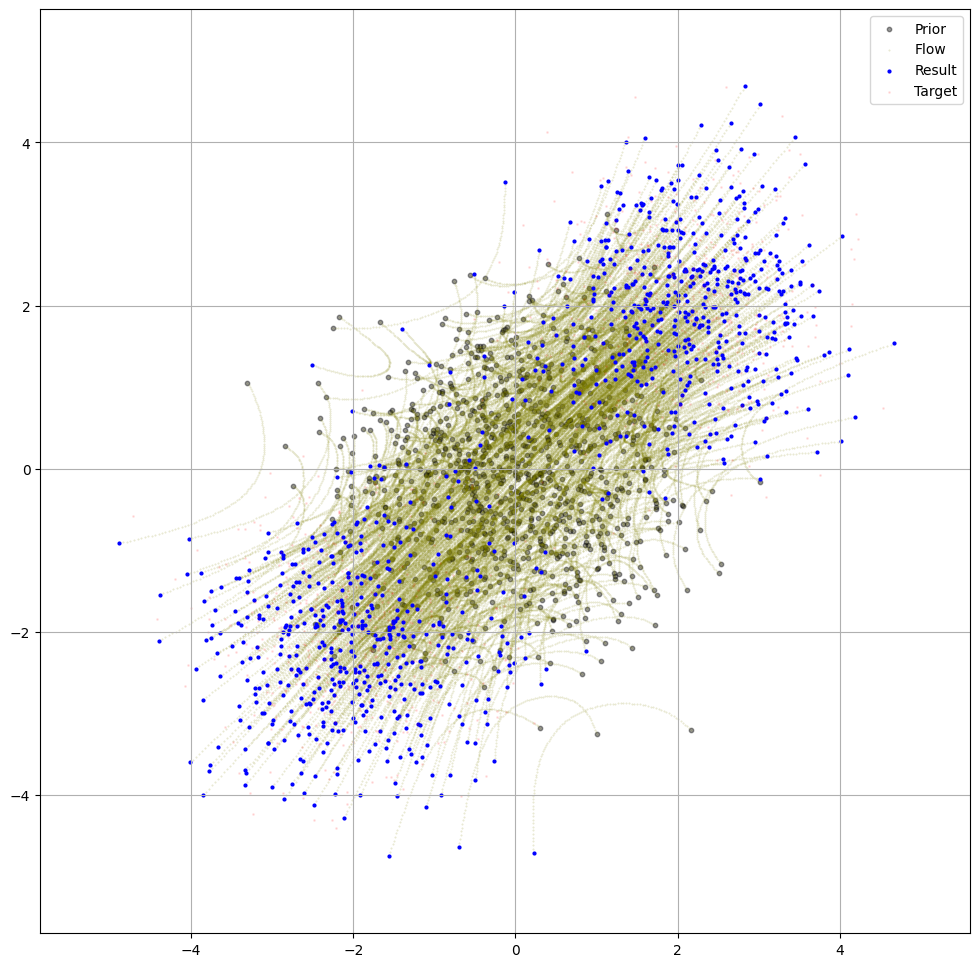

In [11]:
#epoch losses
epochloss_ = plot_epochloss(**asdict(Diag))
epochloss_.ylim(0.0,0.4) #fixing so perspective constant
epochloss_.show()


#trajectories
target = posterior(1000,obs)
source_sample = torch.randn(1000,theta_dim) #[n,theta_dim]


model.eval()
node = NeuralODE(torch_wrapper_FMPE(model, obs = dataset.standardize(obs,label="x")), solver="dopri5", sensitivity="adjoint", atol=1e-5, rtol=1e-5)
with torch.no_grad():
    traj = node.trajectory(source_sample, t_span = torch.linspace(0,1,101)) #[T,n,theta_dim]
    plot_trajectories(dataset.standardize(traj.cpu().numpy(),label="theta",inverse=True)[:,:1000,:2], target = target[:1000,:2])


# MCMC

In [12]:
def log_prior(theta):
    return torch.sum(torch.distributions.Normal(mu[:, 0], sigma[0]).log_prob(theta))

def log_likelihood(theta, obs):
    log_probs = torch.zeros(m)
    for i in range(m):
        component_mean = theta + mu[:, i+1]
        component_std = sigma[i+1]
        log_probs[i] = torch.distributions.Normal(component_mean, component_std).log_prob(obs).sum()
    return torch.logsumexp(torch.log(w) + log_probs, dim=0)

def log_posterior(theta, obs):
    return log_prior(theta) + log_likelihood(theta, obs)

def propose(theta, step_size=1.0, jump_prob=0.1):
    if torch.rand(1).item() < jump_prob:
        return -theta + torch.randn_like(theta) * step_size
    else:
        return theta + torch.randn_like(theta) * step_size

def mcmc_mh_multimodal(n_iterations, initial_theta, obs, step_size=1.0, jump_prob=0.1, thin=20):
    current_theta = initial_theta
    current_log_posterior = log_posterior(current_theta, obs)
    
    samples = [current_theta.clone()]
    accepted = 0
    
    for i in tqdm(range(n_iterations)):
        proposed_theta = propose(current_theta, step_size, jump_prob)
        proposed_log_posterior = log_posterior(proposed_theta, obs)
        
        log_acceptance_ratio = proposed_log_posterior - current_log_posterior
        
        if torch.log(torch.rand(1)) < log_acceptance_ratio:
            current_theta = proposed_theta
            current_log_posterior = proposed_log_posterior
            accepted += 1
        
        if i % thin == 0:
            samples.append(current_theta.clone())
    
    return torch.stack(samples), accepted / n_iterations

# Run MCMC
n_iterations = 10000
initial_theta = torch.zeros(d)
step_size = 1.0
jump_prob = 0.1

samples, acceptance_rate = mcmc_mh_multimodal(n_iterations, initial_theta, obs, step_size, jump_prob, thin = 10)


100%|██████████| 10000/10000 [00:05<00:00, 1759.98it/s]


Acceptance rate: 0.27


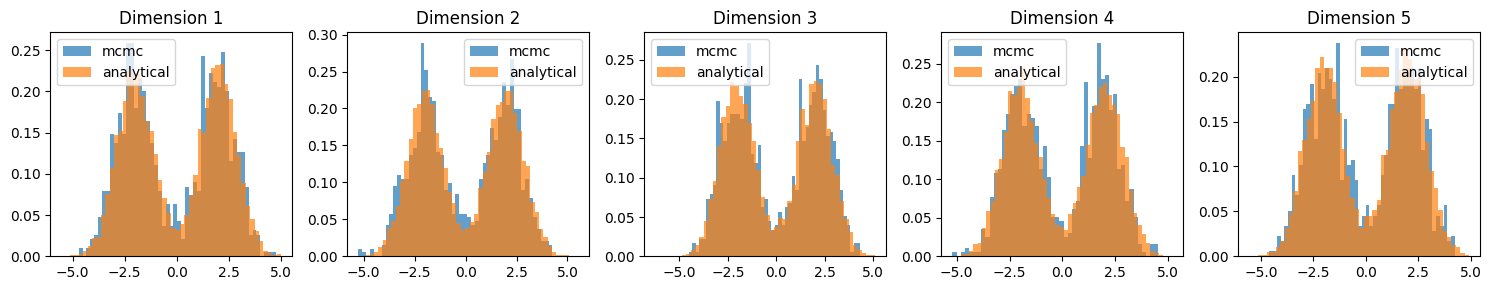

In [13]:
print(f"Acceptance rate: {acceptance_rate:.2f}")

plt.figure(figsize=(3*d, 3))
for i in range(d):
    plt.subplot(1, d, i+1)
    plt.hist(samples[:, i].numpy(), bins=50, density=True, alpha=0.7, label = "mcmc")
    plt.hist(posterior(10001,obs)[:,i], bins = 50, density=True, alpha=0.7, label = "analytical")
    plt.legend()
    plt.title(f"Dimension {i+1}")
plt.tight_layout()
plt.show()

# Plotting

In [14]:
# # 1D version of plot

# # Extract data
# data_fmpe = dataset.standardize(traj.cpu().numpy(), label="theta", inverse=True)[-1, :, :]
# data_mcmc = samples[:10000, :]


# x_values = np.linspace(-6,6, 1000)


# default_colors = plt.cm.tab10.colors  
# plt.figure(figsize=(6, 3)) 
# plt.tick_params(axis='both', which='major', labelsize=18)  

# kde_fmpe = gaussian_kde(data_fmpe[:,0])(x_values)
# kde_mcmc = gaussian_kde(data_mcmc[:,0])(x_values)
# kde_true = gaussian_kde(data_post[:1000,0])(x_values)
# #kde_prior = gaussian_kde(data_prior[:,0])(x_values)

# #ax[dim].plot(x_values,kde_prior,label = "Prior", alpha = 0.2, color = default_colors[0])
# plt.plot(x_values,kde_true,label = "Posterior", alpha = 0.9, color = default_colors[1])
# plt.plot(x_values,kde_fmpe,label = "FMPE",alpha = 0.9, color = default_colors[2])
# plt.plot(x_values,kde_mcmc,label = "MCMC", alpha = 0.5, color = default_colors[3])

# plt.xlabel(r'$\theta$', fontsize = 20)

# # ax[dim].set_title(f"dim = {dim + 1}")

# ax = plt.gca()
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# plt.text(0.02, 0.95, f"dim = {dim + 1}", transform=ax.transAxes, 
#                 fontsize=18, verticalalignment='top', horizontalalignment='left')
# plt.tick_params(axis='both', which='major', labelsize=14)
# plt.legend(handlelength=1, fontsize = 12, loc = "upper right")


# plt.tight_layout()

# # plt.savefig(f'plots/multimodal_densities_{d}d.svg', format='svg', dpi=300)
# # plt.savefig(f'plots/multimodal_densities_{d}d.png', dpi=300)  # PNG with high DPI


# plt.show()


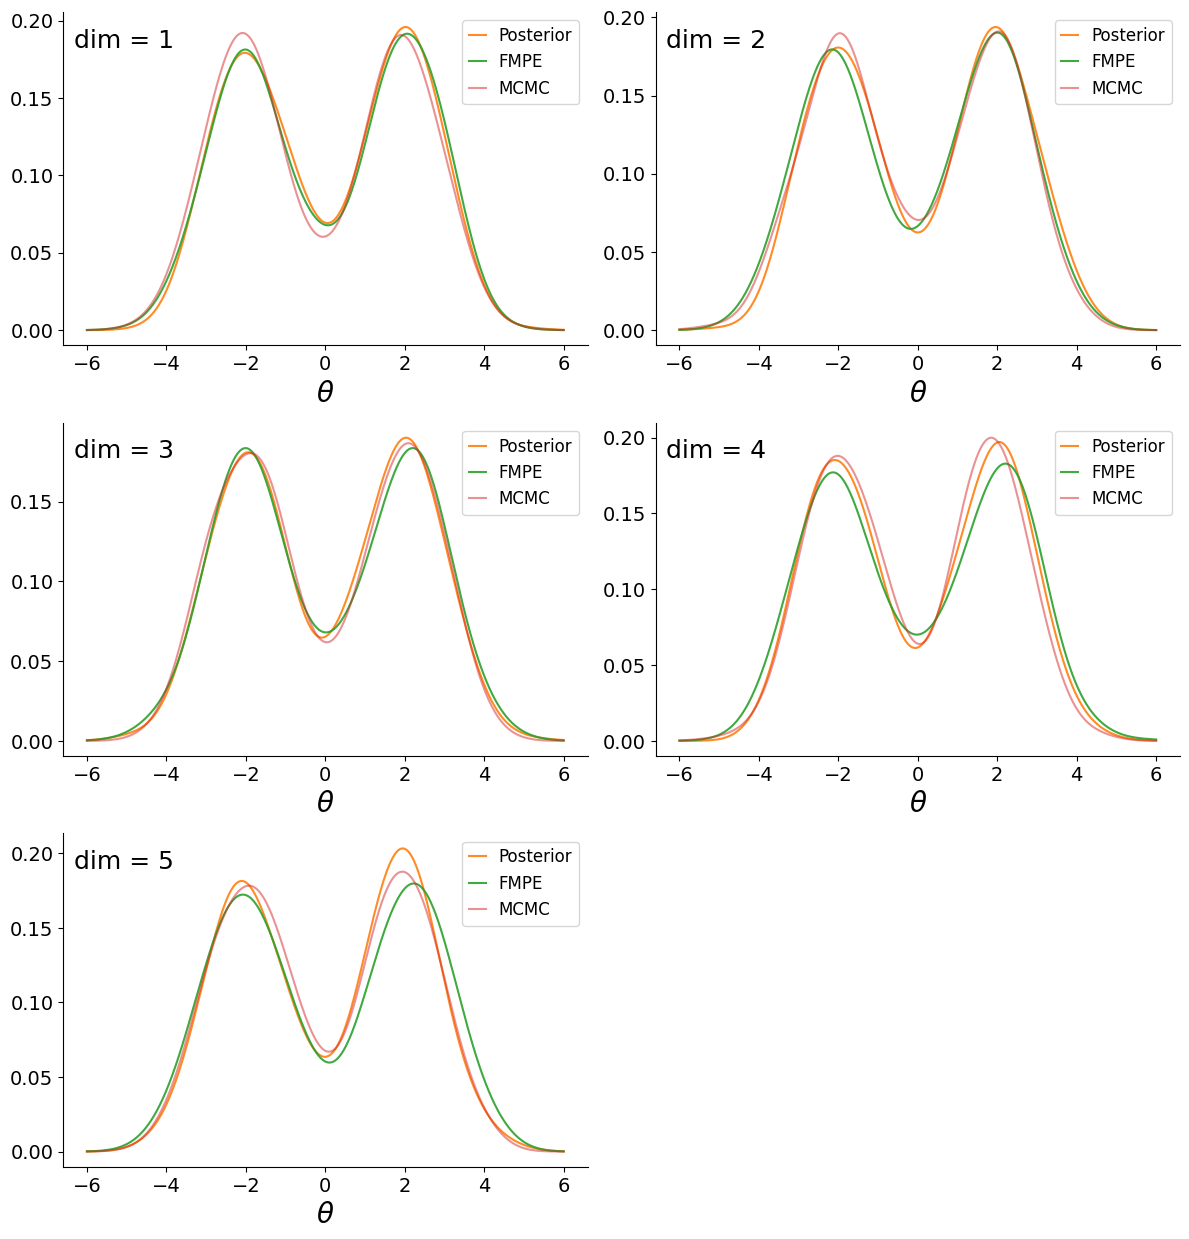

In [20]:
data_fmpe = dataset.standardize(traj.cpu().numpy(), label="theta", inverse=True)[-1, :, :]
data_mcmc = samples[:10000, :]


x_values = np.linspace(-6,6, 1000)


default_colors = plt.cm.tab10.colors  
fig, ax = plt.subplots(theta_dim//2 + 1, 2, figsize=(6*2, 5/2*theta_dim))
ax = ax.flatten()

for dim in range(theta_dim):
    kde_fmpe = gaussian_kde(data_fmpe[:,dim])(x_values)
    kde_mcmc = gaussian_kde(data_mcmc[:,dim])(x_values)
    kde_true = gaussian_kde(data_post[:1000,dim])(x_values)

    ax[dim].plot(x_values,kde_true,label = "Posterior", alpha = 0.9, color = default_colors[1])
    ax[dim].plot(x_values,kde_fmpe,label = "FMPE",alpha = 0.9, color = default_colors[2])
    ax[dim].plot(x_values,kde_mcmc,label = "MCMC", alpha = 0.5, color = default_colors[3])

    ax[dim].set_xlabel(r'$\theta$', fontsize = 20)
    ax[dim].spines['top'].set_visible(False)
    ax[dim].spines['right'].set_visible(False)   
    ax[dim].text(0.02, 0.95, f"dim = {dim + 1}", transform=ax[dim].transAxes, 
                 fontsize=18, verticalalignment='top', horizontalalignment='left')
    ax[dim].tick_params(axis='both', which='major', labelsize=14)
    ax[dim].legend(handlelength=1, fontsize = 12, loc = "upper right")

if d % 2 != 0:
    ax[-1].axis('off')

plt.tight_layout()

# plt.savefig(f'plots/multimodal_densities_{d}d_BIG.svg', format='svg', dpi=300)
# plt.savefig(f'plots/multimodal_densities_{d}d_BIG.png', dpi=300)  # PNG with high DPI


plt.show()




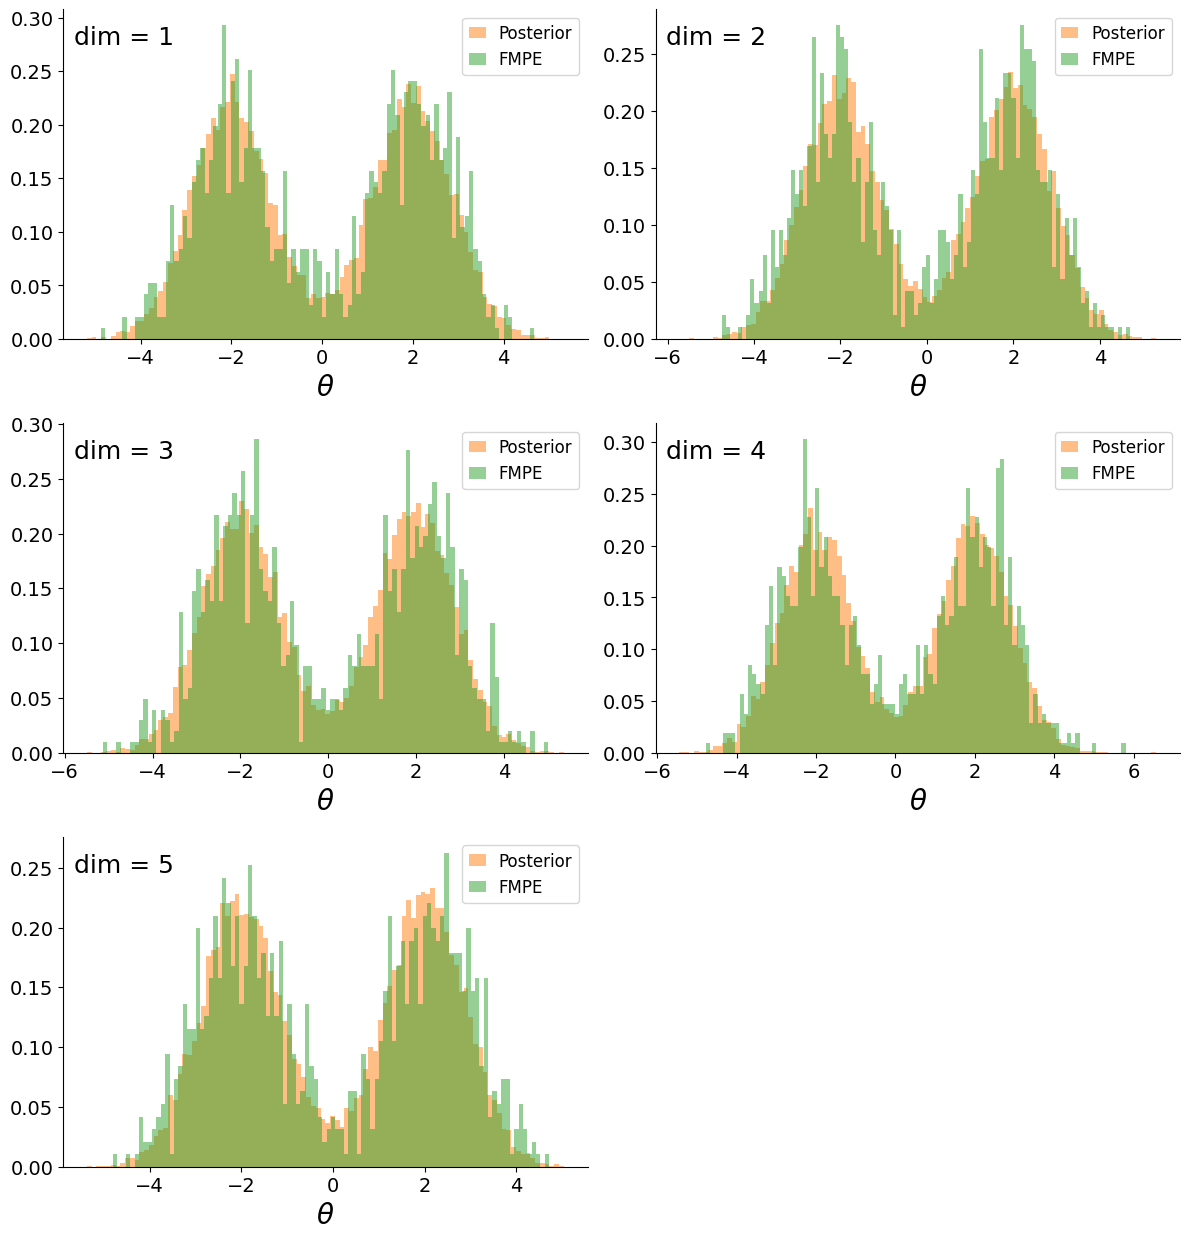

In [16]:
# Check that Gaussian kde is not smoothing fmpe unfairly

default_colors = plt.cm.tab10.colors  
fig, ax = plt.subplots(theta_dim//2 + 1, 2, figsize=(6*2, 5/2*theta_dim))
ax = ax.flatten()

for dim in range(theta_dim):

    ax[dim].hist(data_post[:,dim], bins = 100, density = True, label = "Posterior", alpha = 0.5, color = default_colors[1])
    ax[dim].hist(data_fmpe[:,dim], bins = 100, density = True, label = "FMPE",alpha = 0.5, color = default_colors[2])

    ax[dim].set_xlabel(r'$\theta$', fontsize = 20)
    ax[dim].spines['top'].set_visible(False)
    ax[dim].spines['right'].set_visible(False)   
    ax[dim].text(0.02, 0.95, f"dim = {dim + 1}", transform=ax[dim].transAxes, 
                 fontsize=18, verticalalignment='top', horizontalalignment='left')
    ax[dim].tick_params(axis='both', which='major', labelsize=14)
    ax[dim].legend(handlelength=1, fontsize = 12, loc = "upper right")

if d % 2 != 0:
    ax[-1].axis('off')

plt.tight_layout()

# # plt.savefig(f'plots/multimodal_HIST_{d}d.svg', format='svg', dpi=300)
# # plt.savefig(f'plots/multimodal_HIST_{d}d.png', dpi=300)  # PNG with high DPI

plt.show()

In [17]:
# Dax Figure 4 --- C2ST score
c2st_fmpe = c2st(data_post[:1000,:],torch.tensor(data_fmpe[:1000,:]))
c2st_mcmc = c2st(data_post[:1000,:], data_mcmc[:1000,:], )
print(c2st_fmpe)
print(c2st_mcmc)

tensor([0.5470])
tensor([0.5060])


In [19]:
# # saving & loading the FMPE model

# #save:
# torch.save(model, f'models/multimodal_{d}d.pth')


# # load:
# loaded2 = torch.load(f'models/multimodal_{d}d.pth')